# Анализ маркетинговых затрат

<a id=content></a>
## Содержание.
- 1. Подготовка данных к анализу.
- 2. Рассчёт метрик.
    - 2.1. Продукт.
        - [2.1.1. Метрики DAU, WAU и MAU.](#2_1_1)
        - [2.1.2. Количество сессий в день.](#2_1_2)
        - [2.1.3. Средняя продолжительность сессии (ASL).](#2_1_3)
        - [2.1.4. Коэффициент удержания посетителей (Retention Rate).](#2_1_4)
    - 2.2. Продажи        
        - [2.2.1. Когда люди начинают покупать?](#2_2_1)
        - [2.2.2. Сколько раз покупают за период?](#2_2_2)
        - [2.2.3. Какой средний чек?](#2_2_3)
        - [2.2.4. Сколько денег приносят? (LTV)](#2_2_4)
    - 2.3. Маркетинг
        - [2.3.1. Сколько денег потратили? Всего / на каждый источник / по времени.](#2_3_1)
        - [2.3.2. Сколько стоило привлечение одного покупателя из каждого источника?](#2_3_2)
        - [2.3.3. На сколько окупились расходы? (ROI)](#2_3_3)
- 3. [**Вывод.**](#conclusion)
- 4. [Рекомендация маркетологам](#recommendation)

# 1. Подготовка данных к анализу.

Подключим необходимые библиотеки. Прочитаем исходные файлы и сохраним в переменные. Выведем на экран шапки таблиц.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import math
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

visits = pd.read_csv('datasets/visits_log.csv')
orders = pd.read_csv('datasets/orders_log.csv')
costs  = pd.read_csv('datasets/costs.csv')

In [2]:
visits.head(2)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740


In [3]:
orders.head(2)

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447


In [4]:
costs.head(2)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25


Изменим названия столбцов. Заменем пробелы подчёркиванием, и приведём к нижнему регистру.

In [5]:
visits.columns = ['device', 'end_ts' , 'source_id', 'start_ts', 'uid']
orders.columns = ['buy_ts', 'revenue', 'uid']

Выведем на экран общую информацию.

In [6]:
print(visits.info())
print(orders.info())
print(costs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   device     359400 non-null  object
 1   end_ts     359400 non-null  object
 2   source_id  359400 non-null  int64 
 3   start_ts   359400 non-null  object
 4   uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   buy_ts   50415 non-null  object 
 1   revenue  50415 non-null  float64
 2   uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     -------------- 

Дату и время необходимо перевести в соответствующий формат.

In [7]:
visits['end_ts']   = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
orders['buy_ts']   = pd.to_datetime(orders['buy_ts'])
costs['dt']        = pd.to_datetime(costs['dt'])

Проверим на наличие дубликатов.

In [8]:
print(visits.duplicated().sum())
print(orders.duplicated().sum())
print(costs.duplicated().sum())

0
0
0


**Данные готовы к анализу.**

# 2. Рассчёт метрик.

## 2.1. Продукт.
<a id=2_1_1></a>
### 2.1.1. Метрики DAU, WAU и MAU.
[Содержание](#content)

Cоздадим столбцы со значениями: год, месяц, неделя и день.

In [9]:
visits_visits = visits.copy()
visits_visits['year']  = visits_visits['start_ts'].dt.year
visits_visits['month'] = visits_visits['start_ts'].dt.month
visits_visits['week']  = visits_visits['start_ts'].dt.week
visits_visits['day']   = visits_visits['start_ts'].dt.day
visits_visits.head(2)

,device,end_ts,source_id,start_ts,uid,year,month,week,day
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,19


Рассчитаем метрики.

In [10]:
dau_visits = int(visits_visits.groupby(['year', 'month', 'week', 'day']).agg({'uid': 'nunique'}).mean())
wau_visits = int(visits_visits.groupby(['year', 'month', 'week'       ]).agg({'uid': 'nunique'}).mean())
mau_visits = int(visits_visits.groupby(['year', 'month'               ]).agg({'uid': 'nunique'}).mean())

print('\033[1m' + 'Количество уникальных пользователей:')
print('- в день   (DAU) -', dau_visits)
print('- в неделю (WAU) -', wau_visits)
print('- в месяц  (MAU) -', mau_visits)

Количество уникальных пользователей:
- в день   (DAU) - 907
- в неделю (WAU) - 4911
- в месяц  (MAU) - 23228


Добавим столбец с названием месяца в формате ГГГГ-ММ:

In [11]:
visits_visits['year_month'] = visits_visits['start_ts'].astype('datetime64[M]')
visits_visits.head()

,device,end_ts,source_id,start_ts,uid,year,month,week,day,year_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,20,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,19,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,1,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,20,2018-05-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,27,2017-12-01


Построим график общего количества посещений в месяц, с разбиением по устройствам. Создадим функцию:

In [12]:
def captions_to_graphics(title, xlabel, ylabel):
    '''
    - принимает на вход: заголовок, подпись оси X, подпись оси Y
    - передаёт полученные значения графику, устанавливая определённые свойства:
    - выделяет тексты жирным, задаёт необходимую высоту
    '''
    plt.title(title,
              fontsize=16,
              fontweight='bold')
    plt.xlabel(xlabel,
               fontsize=13,
               fontweight='bold')
    plt.ylabel(ylabel,
               fontsize=13,
               fontweight='bold')

Строим график:

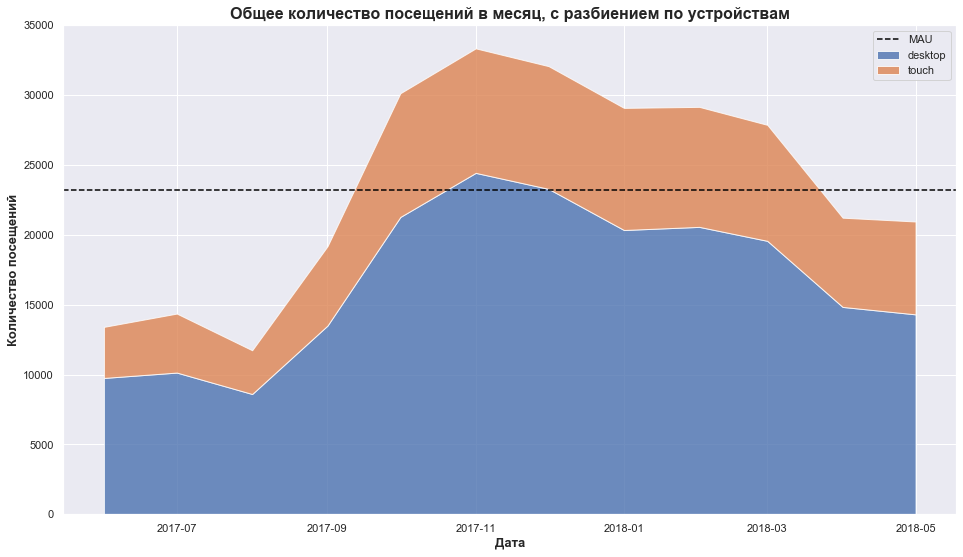

In [13]:
visits_device = visits_visits\
    .groupby(['year', 'year_month', 'device'])\
    .agg({'uid': 'nunique'}).reset_index()

sns.set(style = 'darkgrid')
plt.figure(figsize=(16, 9))
plt.stackplot(
    visits_device[visits_device['device'] == 'desktop']['year_month'],
    visits_device[visits_device['device'] == 'desktop']['uid'],
    visits_device[visits_device['device'] == 'touch']['uid'],
    labels=['desktop','touch'],
    alpha=0.8)
plt.axhline(
    y=mau_visits,
    color='black',
    linestyle='--',
    label='MAU')
captions_to_graphics(
    'Общее количество посещений в месяц, с разбиением по устройствам',
    'Дата',
    'Количество посещений')
plt.legend(loc='upper right')
plt.show()

<a id=2_1_2></a>
### 2.1.2. Количество сессий в день.
[Содержание](#content)

Сгруппируем данные по году/месяцу/недели/дням. Посчитаем количество сессий, и количество уникальных пользователей. Полученные значения поделим друг на друга.

In [14]:
session_in_day = visits_visits\
    .groupby(['year', 'month', 'week', 'day'])\
    .agg({'uid': ['count', 'nunique']})
session_in_day.columns = ['n_session', 'n_users']
session_in_day['session_in_day'] = session_in_day['n_session'] / session_in_day['n_users']
session_in_day.head()

n_session  n_users  session_in_day
year month week day                                    
2017 6     22   1          664      605        1.097521
                2          658      608        1.082237
                3          477      445        1.071910
                4          510      476        1.071429
           23   5          893      820        1.089024

Видно, что количесто сессий не сильно отличается от количества уникальных пользователей. Рассчитаем среднее значение сессий в день на одного посетителя.

In [15]:
session_in_day['session_in_day'].describe()

count    364.000000
mean       1.082170
std        0.020876
min        1.000000
25%        1.070321
50%        1.082488
75%        1.093876
max        1.217837
Name: session_in_day, dtype: float64

In [16]:
print('\033[1m' + 'В среднем, пользователь делает одну сессию в день.')
print('На повторные посещения приходится {:.1%} визитов.'.format(
    (session_in_day['session_in_day'].mean() - 1) / session_in_day['session_in_day'].mean()))

В среднем, пользователь делает одну сессию в день.
На повторные посещения приходится 7.6% визитов.


<a id=2_1_3></a>
### 2.1.3. Средняя продолжительность сессии (ASL).
[Содержание](#content)

Создадим стобец с длительностью сессии в секундах.

In [17]:
visits_visits['session_duration_sec'] = (visits_visits['end_ts'] - visits_visits['start_ts']).dt.seconds
visits_visits.head()

,device,end_ts,source_id,start_ts,uid,year,month,week,day,year_month,session_duration_sec
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,20,2017-12-01,1080
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,19,2018-02-01,1680
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,1,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,20,2018-05-01,1440
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,27,2017-12-01,0


Посмотим на распределение длительности, с помощью гистограммы.

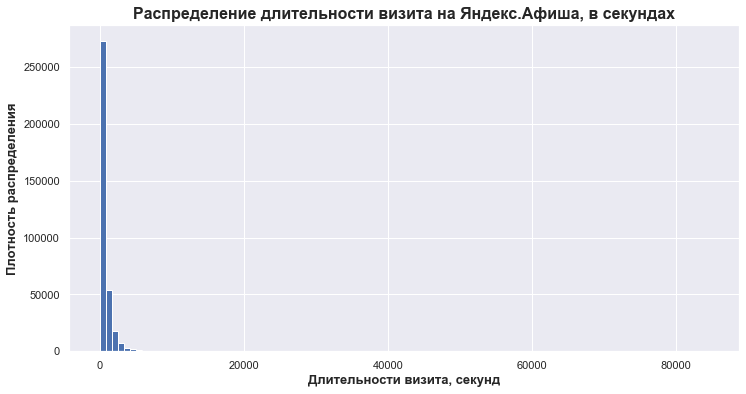

In [18]:
plt.figure(figsize=(12, 6))
visits_visits['session_duration_sec'].hist(bins=100)
captions_to_graphics(
    'Распределение длительности визита на Яндекс.Афиша, в секундах',
    'Длительности визита, секунд',
    'Плотность распределения')
plt.show()

Видим большой всплеск на ноле, и очень длинный хвост. Рассчитаем количество "нулевых" визитов.

In [19]:
print('\033[1m' + '{:.2%} сессий имеют нулевую продолжительность'.format(
    len(visits_visits[visits_visits['session_duration_sec'] == 0]) / len(visits_visits)))

9.96% сессий имеют нулевую продолжительность


Посмотрим на распределение длительности, с помощью функции **describe()**, с обозначением персентилей.

In [20]:
visits_visits['session_duration_sec'].describe(percentiles = [0.01, 0.05, 0.1, 0.9, 0.95, 0.99])

count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
1%            0.000000
5%            0.000000
10%          19.000000
50%         300.000000
90%        1620.000000
95%        2280.000000
99%        4500.000000
max       84480.000000
Name: session_duration_sec, dtype: float64

Отбросим выбросы с нулевой длительностью (~10%), и длительность дольше 1620 секунд (10%). Построим гисторграму распределения.

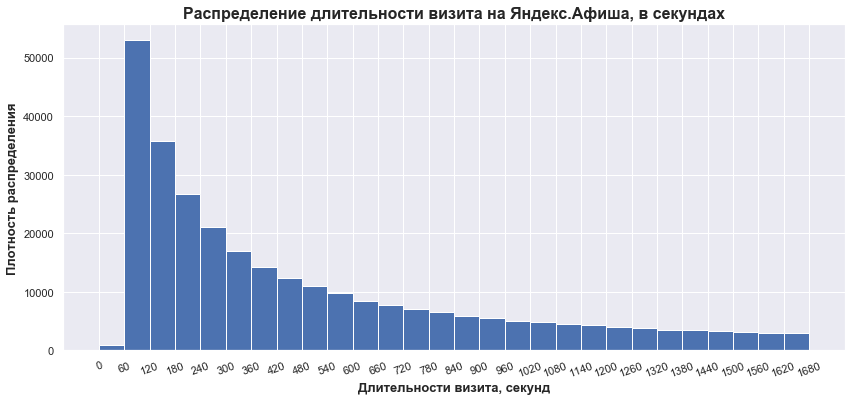

In [21]:
plt.figure(figsize=(14, 6))
visits_visits.query('19 <= session_duration_sec <= 1620')['session_duration_sec']\
    .hist(bins=28, range=(0, 1680)) #1620 / 60 + 1 = 27
plt.xticks(range(0, 1720, 60), rotation=20)
captions_to_graphics(
    'Распределение длительности визита на Яндекс.Афиша, в секундах',
    'Длительности визита, секунд',
    'Плотность распределения')
plt.show()

Рассчитаем среднее значение и моду.

In [22]:
visits_mean_10_90 = visits_visits.query('19 <= session_duration_sec <= 1620')['session_duration_sec'].mean()
visits_mode       = visits_visits                                            ['session_duration_sec'].mode()[0]

print('Средняя длительность визита: {:.0f} секунды.'.format(visits_mean_10_90))
print('Мода    длительности визита:  {:.0f} секунд.'.format(visits_mode))

Средняя длительность визита: 454 секунды.
Мода    длительности визита:  60 секунд.


Проверим, есть ли ещё, помимо моды, часто повторяющиеся знаяения длительности.

In [23]:
visits_visits['session_duration_sec'].value_counts().head(10)

60     53029
0      35794
120    35748
180    26672
240    21085
300    17005
360    14316
420    12301
480    10973
540     9722
Name: session_duration_sec, dtype: int64

Все значения кратны 60 - одной минуте! Все ли значения кратны 60?

In [24]:
len(visits_visits[visits_visits['session_duration_sec'] % 60 != 0])

868

Не все значения кратны 60. Какие это значения?

In [25]:
visits_visits[visits_visits['session_duration_sec'] % 60 != 0].head()

,device,end_ts,source_id,start_ts,uid,year,month,week,day,year_month,session_duration_sec
358532,desktop,2017-11-24 10:14:19,5,2017-11-24 10:14:00,2551852515556206,2017,11,47,24,2017-11-01,19
358533,touch,2018-01-26 19:14:19,1,2018-01-26 19:14:00,21801295586117262,2018,1,4,26,2018-01-01,19
358534,desktop,2017-07-14 15:43:19,1,2017-07-14 15:43:00,45173250638993302,2017,7,28,14,2017-07-01,19
358535,touch,2017-10-04 12:51:19,4,2017-10-04 12:51:00,74720860360798980,2017,10,40,4,2017-10-01,19
358536,desktop,2018-03-25 16:00:19,9,2018-03-25 16:00:00,86768018446815478,2018,3,12,25,2018-03-01,19


Разные: пользователи, устройства, источники и даты визитов. Все ли значения равны 19?

In [26]:
print(len(visits_visits[visits_visits['session_duration_sec'] == 19]))
print(len(visits_visits[visits_visits['session_duration_sec'] == 19]) / len(visits_visits) * 100, '%')

868
0.24151363383416807 %


Длительность сессии в 19 секунд - это четверть процента всех визитов. Получается, гистограмма распредления длительности, полностью повторила график распределения. Проверим, как проходит распределение между платформами.

In [27]:
session_devices = visits_visits.query('0 <= session_duration_sec <= 1620')\
    .pivot_table(index=['session_duration_sec', 'device'], values='uid', aggfunc='count')\
    .sort_values(by='session_duration_sec')
session_devices = session_devices.reset_index()
session_devices = session_devices.rename(columns = {'uid': 'n_visits'})

session_devices.head()

,session_duration_sec,device,n_visits
0,0,desktop,23689
1,0,touch,12105
2,19,desktop,654
3,19,touch,214
4,60,desktop,35411


Построим график:

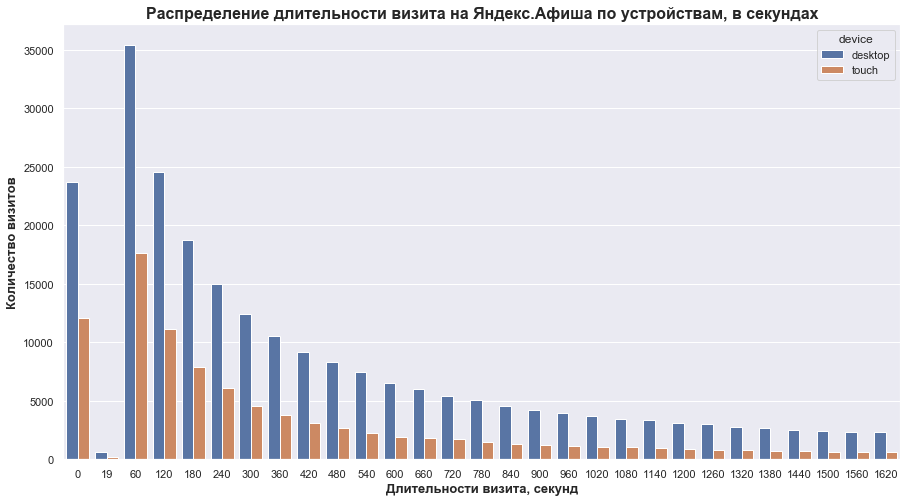

In [28]:
plt.figure(figsize=(15, 8))
sns.barplot(
    x='session_duration_sec',
    y='n_visits',
    hue='device',
    data=session_devices)
captions_to_graphics(
    'Распределение длительности визита на Яндекс.Афиша по устройствам, в секундах',
    'Длительности визита, секунд',
    'Количество визитов')
plt.show()

Если посмотреть на первые строки исходной таблицы, можно увидеть, что начало визитов представляет из себя значение даты и времени кратное минутам. Другими словами, все сессии начинались в "00" секунд каждой минуты. Проверим, так ли это?

In [29]:
pd.DatetimeIndex(visits['start_ts']).second.value_counts()

0    359400
Name: start_ts, dtype: int64

Мы выяснили, что все визиты начинаются ровно с минуты, и **длительность сессий кратна минутам**. Получается, что сервис Яндекс.Афиша округляет начало и конец сессии до минут. При этом, **существует выброс в четверть процента с длительностью 19 секунд**. Определить причину (закономерность) этого выброса по исходной таблице не удалось - **необходимо обратиться в техподдержку сервиса.**

**Cредняя продолжительность сессии (ASL) равна 1й минуте,  
и 50% сессий длятся не более 5 минут.**

Отметим, что нулевая длительность визита - это визиты длительностью менее 30 секунд, округлённые до нуля.

<a id=2_1_4></a>
### 2.1.4. Коэффициент удержания посетителей (Retention Rate).
[Содержание](#content)

В нашем распоряжении данные за один год. Разделим посетителей на когорты по месяцам.
Для этого, создадим столбец с датой первого визита пользователей. 

In [30]:
first_activity_date = visits.groupby('uid')['start_ts'].min()
first_activity_date.name = 'first_activity_date'
first_activity_date.head()

uid
11863502262781    2018-03-01 17:27:00
49537067089222    2018-02-06 15:55:00
297729379853735   2017-06-07 18:47:00
313578113262317   2017-09-18 22:49:00
325320750514679   2017-09-30 14:29:00
Name: first_activity_date, dtype: datetime64[ns]

Добавим его к таблице визитов.

In [31]:
visits = visits.merge(first_activity_date, on='uid')
visits.head()

,device,end_ts,source_id,start_ts,uid,first_activity_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20 17:20:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19 16:53:00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01 01:54:00
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-03-09 20:05:00
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09 20:05:00


Cоздадим столбцы с месяцем первого и текущего визита, и расчитаем время жизни когорты.

In [32]:
visits['first_activity_month'] = visits['first_activity_date'].astype('datetime64[M]')
visits['activity_month']       = visits['start_ts']           .astype('datetime64[M]')

visits['cohort_lifetime'] = visits['start_ts'] - visits['first_activity_date']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1, 'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')
visits.head(3)

,device,end_ts,source_id,start_ts,uid,first_activity_date,first_activity_month,activity_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20 17:20:00,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19 16:53:00,2018-02-01,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01 01:54:00,2017-07-01,2017-07-01,0


Создадим новую таблицу, убрав ненужные столбцы:

In [33]:
visits_uid = visits.drop(['end_ts', 'activity_month'], axis=1).copy()
visits_uid.head(3)

,device,source_id,start_ts,uid,first_activity_date,first_activity_month,cohort_lifetime
0,touch,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20 17:20:00,2017-12-01,0
1,desktop,2,2018-02-19 16:53:00,104060357244891740,2018-02-19 16:53:00,2018-02-01,0
2,touch,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01 01:54:00,2017-07-01,0


Добавим столбец с датой когорты в формате ГГГГ-ММ:

In [34]:
visits_uid['cohort_month'] = visits_uid['first_activity_month'].map(
    lambda x: x.strftime(format = '%Y-%m'))
visits_uid.head(3)

,device,source_id,start_ts,uid,first_activity_date,first_activity_month,cohort_lifetime,cohort_month
0,touch,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20 17:20:00,2017-12-01,0,2017-12
1,desktop,2,2018-02-19 16:53:00,104060357244891740,2018-02-19 16:53:00,2018-02-01,0,2018-02
2,touch,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01 01:54:00,2017-07-01,0,2017-07


Сгруппируем все визиты по когорте (месяцу первого визита) и времени жизни когорты. В качестве данных возьмём количество уникальных пользователей.

In [35]:
cohorts_visits = visits_uid\
    .groupby(['cohort_month', 'cohort_lifetime'])\
    .agg({'uid': 'nunique'}).reset_index()
cohorts_visits.head()

,cohort_month,cohort_lifetime,uid
0,2017-06,0,13259
1,2017-06,1,986
2,2017-06,2,710
3,2017-06,3,813
4,2017-06,4,921


Создадим таблицу с количество визитов пользователей в нулевой месяц жизни когорты.

In [36]:
initial_users_count_visits = cohorts_visits[cohorts_visits['cohort_lifetime'] == 0][['cohort_month', 'uid']]
initial_users_count_visits = initial_users_count_visits.rename(columns = {'uid': 'cohort_users'})
initial_users_count_visits

,cohort_month,cohort_users
0,2017-06,13259
13,2017-07,13140
25,2017-08,10181
36,2017-09,16704
46,2017-10,25977
55,2017-11,27248
63,2017-12,25268
70,2018-01,22624
76,2018-02,22197
81,2018-03,20589


Обратим внимание - количество посещений, начиная с ноября 2017, неуклонно падает. Есть большой прирост в сентябре, и большое падение в апреле. Возможно, это влияние сезонности. Для проверки гипотезы нужны данные, хотя бы за два года.

Отобразим на графике.

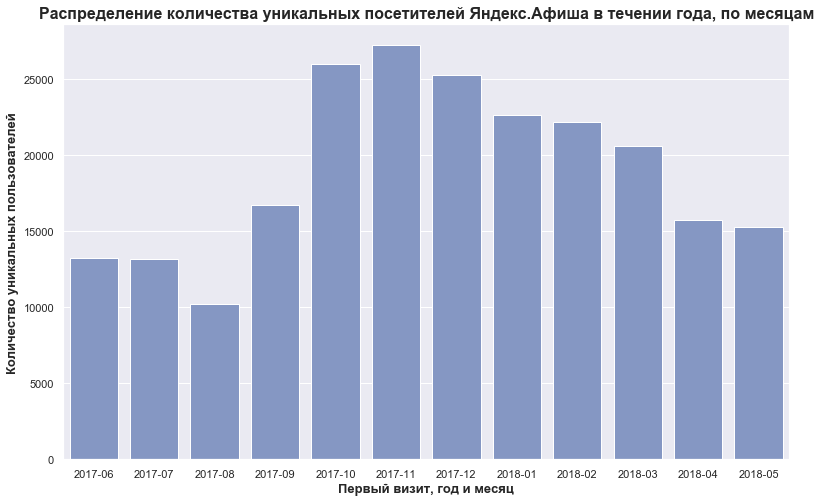

In [37]:
plt.figure(figsize=(13, 8))
sns.barplot(
    x='cohort_month',
    y='cohort_users',
    data=initial_users_count_visits,
    color='#7A93CE')
plt.xticks(rotation=0)
captions_to_graphics(
    'Распределение количества уникальных посетителей Яндекс.Афиша в течении года, по месяцам',
    'Первый визит, год и месяц',
    'Количество уникальных пользователей')
plt.show()

Присоединим к таблице визитов данные по количеству уникальных визитов в нулевой месяц когорты.

In [38]:
cohorts_visits = cohorts_visits.merge(initial_users_count_visits, on = 'cohort_month')
cohorts_visits.head(3)

,cohort_month,cohort_lifetime,uid,cohort_users
0,2017-06,0,13259,13259
1,2017-06,1,986,13259
2,2017-06,2,710,13259


Рассчитаем Retention Rate для каждой когорты.

In [39]:
cohorts_visits['retention'] = cohorts_visits['uid'] / cohorts_visits['cohort_users']
cohorts_visits.head(3)

,cohort_month,cohort_lifetime,uid,cohort_users,retention
0,2017-06,0,13259,13259,1.000000
1,2017-06,1,986,13259,0.074365
2,2017-06,2,710,13259,0.053549


Построим тепловую карту

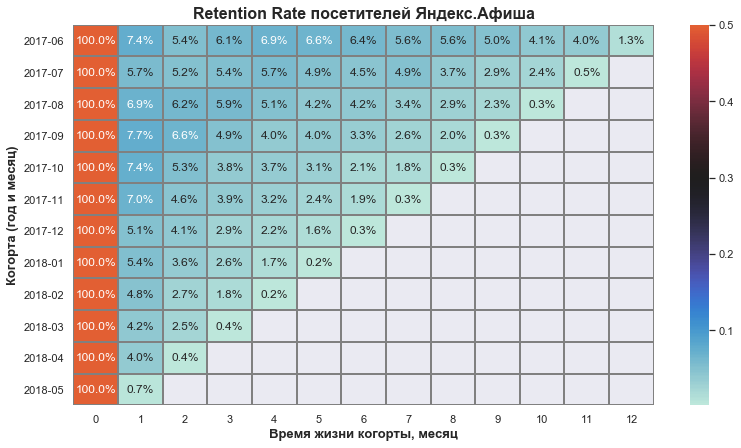

In [40]:
retention_pivot_visits = cohorts_visits.pivot_table(
    index   = 'cohort_month',
    columns = 'cohort_lifetime',
    values  = 'retention')

plt.figure(figsize = (13, 7))
sns.heatmap(
    retention_pivot_visits,
    annot = True,
    fmt = '.1%',
    linewidths = 1,
    linecolor = 'grey',
    vmax=0.5,
    center=0.3)
captions_to_graphics(
    'Retention Rate посетителей Яндекс.Афиша',
    'Время жизни когорты, месяц',
    'Когорта (год и месяц)')
plt.show()

**Retention Rate посетителей Яндекс.Афиша в первый месяц составляет менее 7 %, и начиная с сентября 2017 неуклонно падает.**

**Лучший месяц - сентябрь 2017 года. Когорта этого месяца имеет самый высокий показатель Retention Rate первого месяца. Так же, в этот месяц наблюдается небольшое повышение Retention Rate для предыдущих когорт. Возможно, это связано с сезонностью.**

**Есть большой прирост в сентябре, и большое падение в апреле. Возможно, это влияние сезонности. Для проверки гипотезы нужны данные, хотя бы за два года.**

## 2.2. Продажи.

<a id=2_2_2></a>
### 2.2.2. Когда люди начинают покупать.
[Содержание](#content)

Возьмём исходную таблицу с покупками.

In [41]:
time_to_buy = orders.copy()
time_to_buy.head(3)

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844


Сгруппируем по покупателям, и найдём время первой покупки:

In [42]:
time_to_buy = time_to_buy.groupby('uid').agg({'buy_ts': 'min'}).reset_index()
time_to_buy.head(3)

,uid,buy_ts
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00


Добавим время первого визита

In [43]:
time_to_buy = time_to_buy.merge(first_activity_date, on='uid')
time_to_buy.head(3)

,uid,buy_ts,first_activity_date
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00


Рассчитаем количество дней с первого визита до первой покупки. Нулевые значения заменяем на единицу.

In [44]:
time_to_buy['days_to_buy'] = (
    time_to_buy['buy_ts'] - time_to_buy['first_activity_date']) / np.timedelta64(1, 'D')
time_to_buy['days_to_buy'] = time_to_buy['days_to_buy'].map(lambda x: math.ceil(x))
time_to_buy['days_to_buy'] = time_to_buy['days_to_buy'].replace(0, 1)
time_to_buy.head(3)

,uid,buy_ts,first_activity_date,days_to_buy
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,107
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,1
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00,1


Подберём персентили так, что бы время было разделено на несколько этапов.

In [45]:
time_to_buy['days_to_buy'].describe(percentiles=[0.721])

count    36523.000000
mean        17.729540
std         46.958977
min          1.000000
50%          1.000000
72.1%        1.000000
max        364.000000
Name: days_to_buy, dtype: float64

Дополнительно рассчитаем количество часов и минут с первого визита до первой покупки. Нулевые значения заменяем на единицу.

In [46]:
time_to_buy['hours_to_buy'] = (
    time_to_buy['buy_ts'] - time_to_buy['first_activity_date']) / np.timedelta64(1, 'h')
time_to_buy['hours_to_buy'] = time_to_buy['hours_to_buy'].map(lambda x: math.ceil(x))
time_to_buy['hours_to_buy'] = time_to_buy['hours_to_buy'].replace(0, 1)

time_to_buy['minutes_to_buy'] = (
    time_to_buy['buy_ts'] - time_to_buy['first_activity_date']) / np.timedelta64(1, 'm')
time_to_buy['minutes_to_buy'] = time_to_buy['minutes_to_buy'].map(lambda x: math.ceil(x))
time_to_buy['minutes_to_buy'] = time_to_buy['minutes_to_buy'].replace(0, 1)

print(time_to_buy['hours_to_buy']  .describe(percentiles=[0.618]))
print(time_to_buy['minutes_to_buy'].describe(percentiles=[0.139, 0.316, 0.492]))

count    36523.000000
mean       406.380390
std       1129.668526
min          1.000000
50%          1.000000
61.8%        1.000000
max       8720.000000
Name: hours_to_buy, dtype: float64
count     36523.000000
mean      24340.243052
std       67784.750553
min           1.000000
13.9%         1.000000
31.6%         5.000000
49.2%        15.000000
50%          16.000000
max      523144.000000
Name: minutes_to_buy, dtype: float64


Отобразим в на графике полученные интервалы. Для этого, сформируем отдельную таблицу. Создадим в ней столбцы с помощью функций. За основу берём временные интервалы, полученные выше.

In [47]:
def time_period(data):
    days    = data['days_to_buy']
    hours   = data['hours_to_buy']
    minutes = data['minutes_to_buy']
    if minutes == 1:
        return 1
    if minutes > 1 and minutes <= 5:
        return 2
    if minutes > 5 and minutes <= 15:
        return 3
    if minutes > 15 and minutes <= 60:
        return 4
    if hours > 1 and hours <= 24:
        return 5
    if days > 1 and days <= 30:
        return 6    
    return 7

def time_period_name(row):    
    if row == 1:
        return 'первая минута'
    if row == 2:
        return 'вторая-пятая минуты'
    if row == 3:
        return 'шестая-пятнадцатая\nминуты'
    if row == 4:
        return 'оставшийся час'
    if row == 5:
        return 'оставшиеся сутки'
    if row == 6:
        return 'оставшийся месяц'        
    return 'после месяца'

time_to_buy['time_period']      = time_to_buy               .apply(time_period, axis=1)
time_to_buy['time_period_name'] = time_to_buy['time_period'].apply(time_period_name)
time_to_buy = time_to_buy.sort_values(by='time_period')
time_to_buy.head(3)

,uid,buy_ts,first_activity_date,days_to_buy,hours_to_buy,minutes_to_buy,time_period,time_period_name
16066,8056938532267129292,2017-11-02 11:56:00,2017-11-02 11:56:00,1,1,1,1,первая минута
23375,11800371492608622350,2017-09-25 13:47:00,2017-09-25 13:46:00,1,1,1,1,первая минута
23380,11802944062690236366,2017-11-21 16:07:00,2017-11-21 16:06:00,1,1,1,1,первая минута


Сгруппируем таблицу по временным интервалам. Добавим дополнительные солбцы.

In [48]:
first_order_periods = time_to_buy\
    .groupby('time_period_name', as_index=False)\
    .agg({'uid': 'count', 'time_period': 'min'})
first_order_periods = first_order_periods\
    .sort_values(by='time_period')\
    .reset_index(drop=True)
first_order_periods.columns = ['time_period_name', 'count', 'time_period']

data = [
    ['1 минута'  , '1 минута'],
    ['4 минуты'  , '5 минут' ], 
    ['10 минут'  , '15 минут'],
    ['45 минут'  , '1 час'   ],
    ['23 часа'   , '1 день'  ],
    ['29 дней'   , '1 месяц' ],
    ['11 месяцев', '1 год'   ]    
]

columns = ['time_count', 'time_count_total']
time_count = pd.DataFrame(data=data, columns=columns)

first_order_periods = first_order_periods.join(time_count)
first_order_periods

,time_period_name,count,time_period,time_count,time_count_total
0,первая минута,5111,1,1 минута,1 минута
1,вторая-пятая минуты,6447,2,4 минуты,5 минут
2,шестая-пятнадцатая\nминуты,6429,3,10 минут,15 минут
3,оставшийся час,4621,4,45 минут,1 час
4,оставшиеся сутки,3759,5,23 часа,1 день
5,оставшийся месяц,5192,6,29 дней,1 месяц
6,после месяца,4964,7,11 месяцев,1 год


Отобразим на графике:

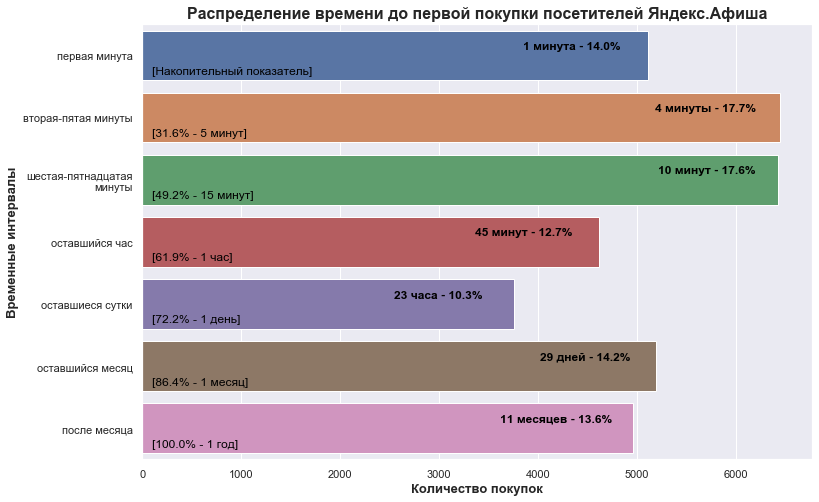

In [49]:
plt.figure(figsize=(12, 8))
q = sns.barplot(
    x='count',
    y='time_period_name',
    data=first_order_periods)

count_all_accumulation = 0
for index, row in first_order_periods.iterrows():    
    len_text = len(row['time_count']) + len(str(row['count'] / len(time_to_buy))) + 1
    q.text(
        x=row['count'] - len_text * 45,
        y=index - 0.1,
        s='{} - {:.1%}'.format(row['time_count'], row['count'] / len(time_to_buy)),
        color='black',
        fontweight='bold')    
    count_all_accumulation += row['count']
    if index != 0:
        q.text(
            x=100,
            y=index + 0.3,
            s='[{:.1%} - {}]'.format(count_all_accumulation / len(time_to_buy), row['time_count_total']),
            color='black')    
    else:
        q.text(
            x=100,
            y=index + 0.3,
            s='[Накопительный показатель]',
            color='black')

captions_to_graphics(
    'Распределение времени до первой покупки посетителей Яндекс.Афиша',
    'Количество покупок',
    'Временные интервалы')
plt.show()

**Cредняя продолжительность сессии (ASL) равна 1й минуте. На этот интервал приходится 14% покупок.  
50% сессий длятся не более 5 минут. На этот интервал приходится 31.6% покупок.  
В течении 15 минут совершается почти половина покупок (49.2%).**

<a id=2_2_3></a>
### 2.2.3. Сколько раз покупают за период?
[Содержание](#content)

Воспользуемся таблицей покупок. Присоединим время первого визита.

In [50]:
cohort_orders = orders.copy()
cohort_orders = cohort_orders.merge(first_activity_date, on='uid')
cohort_orders.head(3)

,buy_ts,revenue,uid,first_activity_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00


Создадим столбцы с месяцем первого визита, и месяцем покупки. По ним, рассчитаем время жизни когорты:

In [51]:
cohort_orders['first_activity_month'] = cohort_orders['first_activity_date'].astype('datetime64[M]')
cohort_orders['activity_month']       = cohort_orders['buy_ts']             .astype('datetime64[M]')

cohort_orders['cohort_lifetime'] = cohort_orders['buy_ts'] - cohort_orders['first_activity_date']
cohort_orders['cohort_lifetime'] = cohort_orders['cohort_lifetime'] / np.timedelta64(1, 'M')
cohort_orders['cohort_lifetime'] = cohort_orders['cohort_lifetime'].round().astype('int')
cohort_orders.head(3)

,buy_ts,revenue,uid,first_activity_date,first_activity_month,activity_month,cohort_lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,2017-06-01,2017-06-01,0


Добавим столбец **cohort_month** с датой когорты в формате ГГГГ-ММ. Создадим новую таблицу, убрав ненужные столбцы:

In [52]:
cohort_orders['cohort_month'] = cohort_orders['first_activity_month'].map(lambda x: x.strftime(format = '%Y-%m'))
cohort_orders['date'] = cohort_orders['buy_ts'].dt.date
cohort_orders = cohort_orders.drop([
    'buy_ts',
    'first_activity_date',
    'activity_month',
    'first_activity_month'],
    axis=1)
cohort_orders.head(3)

,revenue,uid,cohort_lifetime,cohort_month,date
0,17.00,10329302124590727494,0,2017-06,2017-06-01
1,0.55,11627257723692907447,0,2017-06,2017-06-01
2,0.37,17903680561304213844,0,2017-06,2017-06-01


Создадим сводную таблицу по когортам и времени жизни:

In [53]:
cohort_orders_pivot = cohort_orders.pivot_table(
    index='cohort_month',
    columns='cohort_lifetime',
    values='revenue',
    aggfunc='count')
cohort_orders_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,,
2017-06,2334.0,358.0,267.0,404.0,514.0,365.0,548.0,345.0,356.0,348.0,226.0,237.0,95.0
2017-07,1977.0,176.0,219.0,175.0,180.0,182.0,140.0,165.0,144.0,90.0,75.0,22.0,NaN
2017-08,1390.0,201.0,197.0,176.0,160.0,103.0,124.0,123.0,85.0,70.0,9.0,NaN,NaN
2017-09,2616.0,411.0,311.0,259.0,160.0,196.0,181.0,101.0,97.0,14.0,NaN,NaN,NaN
2017-10,4320.0,543.0,375.0,242.0,266.0,194.0,126.0,148.0,19.0,NaN,NaN,NaN,NaN
2017-11,4095.0,600.0,403.0,314.0,253.0,158.0,141.0,19.0,NaN,NaN,NaN,NaN,NaN
2017-12,4011.0,430.0,293.0,223.0,134.0,120.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,3026.0,388.0,236.0,111.0,95.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,3238.0,352.0,143.0,114.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Построим тепловую карту:

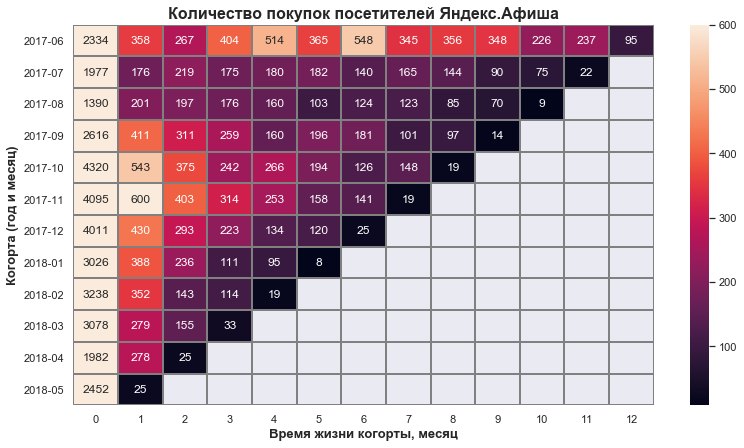

In [54]:
plt.figure(figsize = (13, 7))
sns.heatmap(
    cohort_orders_pivot,
    annot = True,
    fmt = '.0f',
    linewidths = 1,
    linecolor = 'grey',
    vmax=600)
captions_to_graphics(
    'Количество покупок посетителей Яндекс.Афиша',
    'Время жизни когорты, месяц',
    'Когорта (год и месяц)')
plt.show()

**Самая стабильная когорта по количеству покупок - "2017-06". В остальных когортах количество покупок неуклонно падает.**  
**С октября по декабрь наблюдается пик продаж.**

Рассчитаем среднее накопительное количество покупок за пол года.

Сгруппируем данные по когортам и времени жизни. Рассчитаем количество покупок, и уникальных пользователей. 

In [55]:
cohort_orders_gb = cohort_orders\
    .groupby(['cohort_month', 'cohort_lifetime'])\
    .agg({'revenue': 'count', 'uid': 'nunique'}).reset_index()
cohort_orders_gb.head(5)

,cohort_month,cohort_lifetime,revenue,uid
0,2017-06,0,2334,2032
1,2017-06,1,358,214
2,2017-06,2,267,139
3,2017-06,3,404,173
4,2017-06,4,514,251


Для рассчёта выделим данные только тех когорт, по которым есть сведения за пол года.

In [56]:
cohort_orders_gb = cohort_orders_gb[
    (cohort_orders_gb['cohort_month'] <= '2017-12') &
    (cohort_orders_gb['cohort_lifetime'] <= 5)]
cohort_orders_gb.head(7)

,cohort_month,cohort_lifetime,revenue,uid
0,2017-06,0,2334,2032
1,2017-06,1,358,214
2,2017-06,2,267,139
3,2017-06,3,404,173
4,2017-06,4,514,251
5,2017-06,5,365,186
13,2017-07,0,1977,1753


Сгруппируем данные по когортам. Рассчитаем сумму покупок и количество покупателей за пол года жизни. Рассчитаем среднее количество покупок на пользователя, и умножим на время жизни (6 месяцев):

In [57]:
cohort_orders_gb = cohort_orders_gb\
    .groupby('cohort_month', as_index=False)\
    .agg({'revenue': 'sum', 'uid': 'sum'})
cohort_orders_gb['purchases_mean'] = cohort_orders_gb['revenue'] / cohort_orders_gb['uid']
cohort_orders_gb['purchases_mean'] = cohort_orders_gb['purchases_mean'].round(1)
cohort_orders_gb

,cohort_month,revenue,uid,purchases_mean
0,2017-06,4242,2995,1.4
1,2017-07,2909,2459,1.2
2,2017-08,2227,1780,1.3
3,2017-09,3953,3281,1.2
4,2017-10,5940,5098,1.2
5,2017-11,5823,4628,1.3
6,2017-12,5211,4378,1.2


Построим график по полученным данным

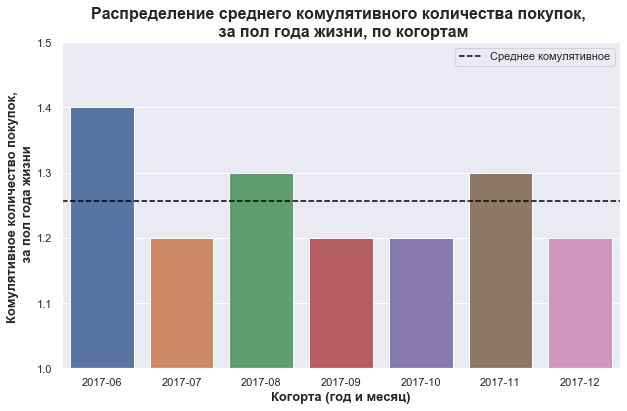

In [58]:
plt.figure(figsize = (10, 6))
sns.barplot(
    x=cohort_orders_gb['cohort_month'],
    y=cohort_orders_gb['purchases_mean'],
    data=cohort_orders_gb)
plt.axhline(
    y=cohort_orders_gb['purchases_mean'].mean(),
    color='black',
    linestyle='--',
    label='Среднее комулятивное')
captions_to_graphics(
    'Распределение среднего комулятивного количества покупок, \n за пол года жизни, по когортам',
    'Когорта (год и месяц)',
    'Комулятивное количество покупок, \n за пол года жизни')
plt.ylim((1, 1.5))
plt.legend()
plt.show()

Выведем среднее:

In [59]:
print('\033[1m' + 'Среднее комулятивное количество покупок, за пол года жизни когорт = {:.1f}'\
      .format(cohort_orders_gb['purchases_mean'].mean()))

Среднее комулятивное количество покупок, за пол года жизни когорт = 1.3


<a id=2_2_4></a>
### 2.2.4. Какой средний чек?
[Содержание](#content)

Проверим данные о выручке. Построим гисторамму распределения:

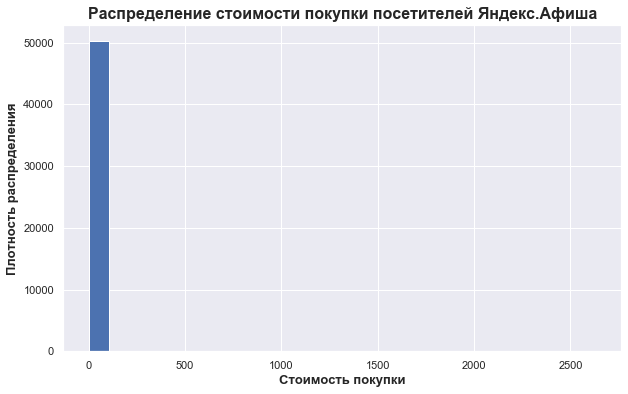

In [60]:
plt.figure(figsize = (10, 6))
plt.hist(cohort_orders['revenue'], bins=25)
captions_to_graphics(
    'Распределение стоимости покупки посетителей Яндекс.Афиша',
    'Стоимость покупки',
    'Плотность распределения')
plt.show()

Очень большой выброс. Исследуем с помощью персентилей:

In [61]:
cohort_orders['revenue'].describe(percentiles=[0.95, 0.99, 0.999])

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
50%          2.500000
95%         13.750000
99%         36.670000
99.9%      175.391420
max       2633.280000
Name: revenue, dtype: float64

Убираем десятую долю процента аномальных покупок:

In [62]:
cohort_orders_clean = cohort_orders[cohort_orders['revenue'] <= 175].copy()
cohort_orders_clean.head(3)

,revenue,uid,cohort_lifetime,cohort_month,date
0,17.00,10329302124590727494,0,2017-06,2017-06-01
1,0.55,11627257723692907447,0,2017-06,2017-06-01
2,0.37,17903680561304213844,0,2017-06,2017-06-01


Сгруппируем по когортам и месяцу покупки. В значениях поссчитаем сумму покупок и количество уникальных пользователей. Разделим значения двух столбцов, чтобы получить средний чек.

In [63]:
cohort_orders_check = cohort_orders_clean\
    .groupby(['cohort_month', 'cohort_lifetime'])\
    .agg({'revenue': 'sum', 'uid': 'nunique'}).reset_index()
cohort_orders_check['revenue_per_user'] = cohort_orders_check['revenue'] / cohort_orders_check['uid']
cohort_orders_check.head()

,cohort_month,cohort_lifetime,revenue,uid,revenue_per_user
0,2017-06,0,8968.06,2032,4.413415
1,2017-06,1,2361.64,214,11.035701
2,2017-06,2,1445.11,139,10.396475
3,2017-06,3,2724.70,173,15.749711
4,2017-06,4,4185.03,251,16.673426


Построим сводную таблицу по когорте и времени жизни:

In [64]:
cohort_orders_check_pivot = cohort_orders_check\
    .pivot_table(index='cohort_month',
                 columns='cohort_lifetime',
                 values='revenue_per_user',
                 aggfunc='mean')
cohort_orders_check_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,,
2017-06,4.413415,11.035701,10.396475,15.749711,16.673426,11.867312,17.336244,13.362400,14.725028,19.912980,17.622479,12.187744,8.575763
2017-07,5.670816,7.113520,7.448875,6.861168,5.891620,5.553873,4.960083,6.706947,5.962241,7.401972,5.673750,7.898095,NaN
2017-08,5.209642,6.955515,7.909280,8.285289,7.243021,7.142603,6.051667,13.548841,16.214902,6.413469,3.347778,NaN,NaN
2017-09,5.152105,10.070456,8.156255,15.839250,11.350240,10.896667,6.586194,6.870429,4.361071,4.581818,NaN,NaN,NaN
2017-10,4.854996,7.724231,5.790432,4.545337,5.734562,5.511667,4.019744,6.066637,3.273750,NaN,NaN,NaN,NaN
2017-11,4.837265,5.029507,5.884829,6.170152,5.722191,6.268596,5.223153,3.201111,NaN,NaN,NaN,NaN,NaN
2017-12,4.491041,5.927557,5.421584,7.028795,6.353600,5.656421,2.712083,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,4.067760,6.495535,6.053780,4.051556,5.494932,8.170000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,4.046326,7.583202,6.572589,5.317381,7.821667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Отобразим средний чек по когортам на тепловой карте:

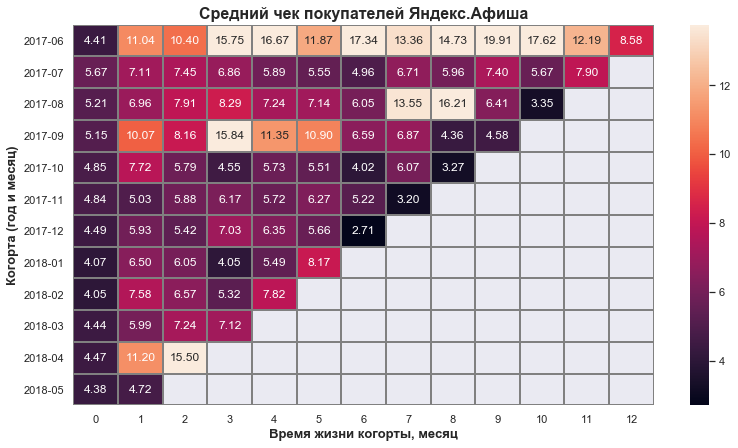

In [65]:
plt.figure(figsize = (13, 7))
sns.heatmap(
    cohort_orders_check_pivot,
    annot = True,
    fmt = '.2f',
    linewidths = 1,
    linecolor = 'grey',
    vmax = 13.75)
captions_to_graphics(
    'Средний чек покупателей Яндекс.Афиша',
    'Время жизни когорты, месяц',
    'Когорта (год и месяц)')
plt.show()

Для рассчёта усреднённого значения, воспользуемся таблицей **cohort_orders_check**

In [66]:
cohort_orders_check.head(3)

,cohort_month,cohort_lifetime,revenue,uid,revenue_per_user
0,2017-06,0,8968.06,2032,4.413415
1,2017-06,1,2361.64,214,11.035701
2,2017-06,2,1445.11,139,10.396475


Выбирем данные по 7 когортам за пол года жизни:

In [67]:
mean_check = cohort_orders_check[
    (cohort_orders_check['cohort_month'] <= '2017-12') &
    (cohort_orders_check['cohort_lifetime'] <= 5)]
mean_check.head(7)

,cohort_month,cohort_lifetime,revenue,uid,revenue_per_user
0,2017-06,0,8968.06,2032,4.413415
1,2017-06,1,2361.64,214,11.035701
2,2017-06,2,1445.11,139,10.396475
3,2017-06,3,2724.70,173,15.749711
4,2017-06,4,4185.03,251,16.673426
5,2017-06,5,2207.32,186,11.867312
13,2017-07,0,9940.94,1753,5.670816


Сгруппируем по когортам, рассчитаем сумму выручки и количество покупателей. Разделим, для получения среднего чека

In [68]:
mean_check = mean_check\
    .groupby('cohort_month', as_index=False)\
    .agg({'revenue': 'sum', 'uid': 'sum'})
mean_check['mean_check'] = mean_check['revenue'] / mean_check['uid']

mean_check

,cohort_month,revenue,uid,mean_check
0,2017-06,21891.86,2995,7.309469
1,2017-07,14587.19,2459,5.932163
2,2017-08,10556.52,1780,5.930629
3,2017-09,22426.74,3280,6.837421
4,2017-10,26453.92,5097,5.190096
5,2017-11,23324.03,4627,5.040854
6,2017-12,21017.69,4376,4.802946


Построим график для визуализации:

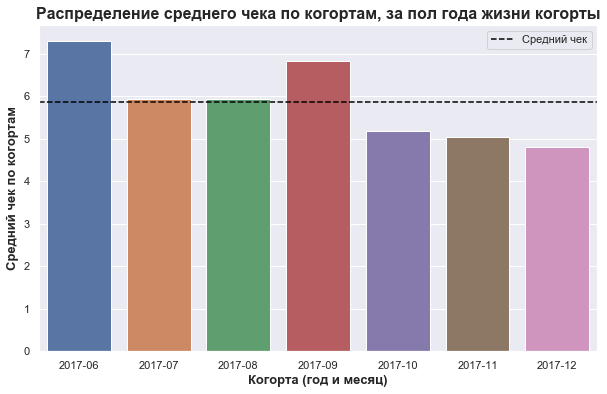

In [69]:
plt.figure(figsize = (10, 6))
sns.barplot(
    x=mean_check['cohort_month'],
    y=mean_check['mean_check'],
    data=mean_check)
plt.axhline(
    y=mean_check['mean_check'].mean(),
    color='black',
    linestyle='--',
    label='Средний чек')
captions_to_graphics(
    'Распределение среднего чека по когортам, за пол года жизни когорты',
    'Когорта (год и месяц)',
    'Средний чек по когортам')
plt.legend()
plt.show()

In [70]:
print('\033[1m' + 'Средний чек за первые пол года жизни когорт = {:.1f}'\
      .format(mean_check['mean_check'].mean()))

Средний чек за первые пол года жизни когорт = 5.9


**Средний чек падает от когорты к когорте. Исключение - сентябрьская когорта.**

<a id=2_2_5></a>
### 2.2.5. Сколько денег приносят? (LTV).
[Содержание](#content)

Воспользуемся таблицей со средним чеком:

In [71]:
cohort_orders_check.head(3)

,cohort_month,cohort_lifetime,revenue,uid,revenue_per_user
0,2017-06,0,8968.06,2032,4.413415
1,2017-06,1,2361.64,214,11.035701
2,2017-06,2,1445.11,139,10.396475


Создадим таблицу с когортой и количеством покупателей в ней:

In [72]:
initial_users_count_orders = cohort_orders_check[
    cohort_orders_check['cohort_lifetime'] == 0
                                                ][['cohort_month', 'uid']]
initial_users_count_orders = initial_users_count_orders.rename(columns = {'uid': 'cohort_buyer'})
initial_users_count_orders

,cohort_month,cohort_buyer
0,2017-06,2032
13,2017-07,1753
25,2017-08,1229
36,2017-09,2309
46,2017-10,3793
55,2017-11,3448
63,2017-12,3487
70,2018-01,2697
76,2018-02,2896
81,2018-03,2659


Добавим количество покупателей к таблице со средним чеком. Рассчитаем среднюю выручку от покупателей.

In [73]:
cohort_orders_ltv = cohort_orders_check[['cohort_month', 'cohort_lifetime', 'revenue']]\
    .merge(initial_users_count_orders, how='left', on='cohort_month')

cohort_orders_ltv['revenue_per_user'] = cohort_orders_ltv['revenue'] / cohort_orders_ltv['cohort_buyer']

cohort_orders_ltv.head(3)

,cohort_month,cohort_lifetime,revenue,cohort_buyer,revenue_per_user
0,2017-06,0,8968.06,2032,4.413415
1,2017-06,1,2361.64,2032,1.162224
2,2017-06,2,1445.11,2032,0.711176


Мы не располагаем маржинальностью, и считаем, что она равна 100%. Умножим средний чек на маржинальность.

In [74]:
margin_rate = 1.0

cohort_orders_ltv['ltv'] = cohort_orders_ltv['revenue_per_user'] * margin_rate
cohort_orders_ltv.head(3)

,cohort_month,cohort_lifetime,revenue,cohort_buyer,revenue_per_user,ltv
0,2017-06,0,8968.06,2032,4.413415,4.413415
1,2017-06,1,2361.64,2032,1.162224,1.162224
2,2017-06,2,1445.11,2032,0.711176,0.711176


Сформируем сводную таблицу по когортам и месяцам жизни:

In [75]:
cohort_ltv_pivot = cohort_orders_ltv.pivot_table(
    index='cohort_month',
    columns='cohort_lifetime',
    values='ltv',
    aggfunc='mean')
cohort_ltv_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,,
2017-06,4.413415,1.162224,0.711176,1.340896,2.059562,1.086280,1.680728,0.986398,1.311629,1.479754,1.049370,0.797721,0.249001
2017-07,5.670816,0.507239,0.679875,0.536212,0.477245,0.449886,0.342367,0.501204,0.394535,0.299795,0.207142,0.094615,NaN
2017-08,5.209642,0.769691,0.804443,0.815720,0.565769,0.424255,0.472710,0.760675,0.672872,0.255704,0.024516,NaN,NaN
2017-09,5.152105,1.338948,0.830108,1.097566,0.614456,0.679567,0.382222,0.208285,0.158653,0.021828,NaN,NaN,NaN
2017-10,4.854996,0.847161,0.459510,0.249257,0.328078,0.235405,0.123994,0.180736,0.013810,NaN,NaN,NaN,NaN
2017-11,4.837265,0.621395,0.448872,0.354318,0.295403,0.207256,0.168147,0.016711,NaN,NaN,NaN,NaN,NaN
2017-12,4.491041,0.521870,0.343611,0.334609,0.182208,0.154104,0.018666,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,4.067760,0.652684,0.368120,0.135202,0.148732,0.021205,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,4.046326,0.597020,0.254189,0.154233,0.048615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Для рассчёта LTV необходимо произвести накопительное суммирование. Отобразим на тепловой карте.

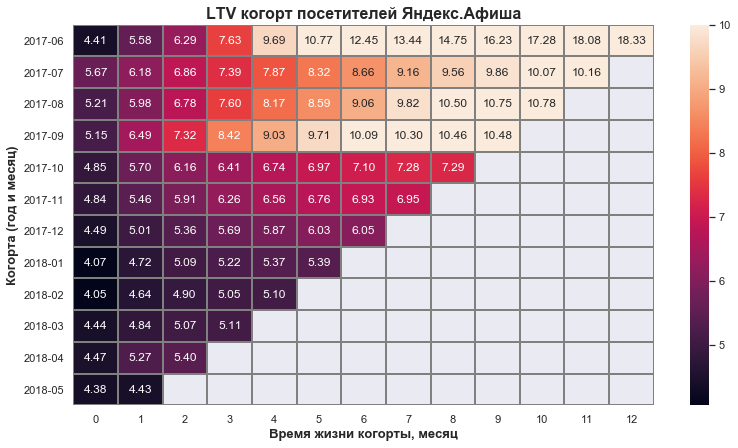

In [76]:
cohort_ltv_pivot = cohort_ltv_pivot.cumsum(axis=1).round(2)

plt.figure(figsize = (13, 7))
sns.heatmap(
    cohort_ltv_pivot,
    annot = True,
    fmt = '.2f',
    linewidths = 1,
    linecolor = 'grey',
    vmax = 10)
captions_to_graphics(
    'LTV когорт посетителей Яндекс.Афиша',
    'Время жизни когорты, месяц',
    'Когорта (год и месяц)')
plt.show()

**Для сравнения возьмём время жизни в 6 месяцев. В рассчёт попадают 7 когорт. За этот промежуток времени, LTV по когортам упало почти вдвое.**

In [77]:
print('\033[1m' + 'Среднее LTV за пол года = {:.2f}'.format(cohort_ltv_pivot[5].mean()))

Среднее LTV за пол года = 7.82


## 2.3. Маркетинг.
<a id=2_3_1></a>
### 2.3.1. Сколько денег потратили? Всего / на каждый источник / по времени.
[Содержание](#content)

Возьмём таблицу расходов:

In [78]:
costs.head(3)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53


Проверим номера источников

In [79]:
costs['source_id'].value_counts()

5     364
9     363
3     363
1     363
10    363
4     363
2     363
Name: source_id, dtype: int64

У источника №5 больше данных, чем у остальных. Проверим диапазон дат:

In [80]:
costs[costs['source_id'] == 5]['dt'].describe()

count                     364
unique                    364
top       2017-10-30 00:00:00
freq                        1
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: dt, dtype: object

In [81]:
costs[costs['source_id'] == 9]['dt'].describe()

count                     363
unique                    363
top       2017-10-30 00:00:00
freq                        1
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: dt, dtype: object

Попробуем найти дату, которой нет у других источников:

In [82]:
costs['dt'] = costs['dt'].dt.date
costs = costs.rename(columns = {'dt': 'date'})
costs['date'].value_counts()

2017-11-02    7
2017-09-28    7
2018-04-04    7
2018-05-05    7
2018-04-09    7
             ..
2017-06-29    7
2017-09-26    7
2017-12-18    7
2018-04-10    7
2018-03-31    1
Name: date, Length: 364, dtype: int64

31 марта 2018.

Сгруппируем по месяцу и источнику. Расходы просуммируем:

In [83]:
costs['date_month'] = costs['date'].astype('datetime64[M]')
costs_gr = costs.groupby(['date_month', 'source_id']).agg({'costs': 'sum'}).reset_index()
costs_gr.head(7)

,date_month,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12
5,2017-06-01,9,285.22
6,2017-06-01,10,314.22


Построим график расходов по месяцам и источникам:

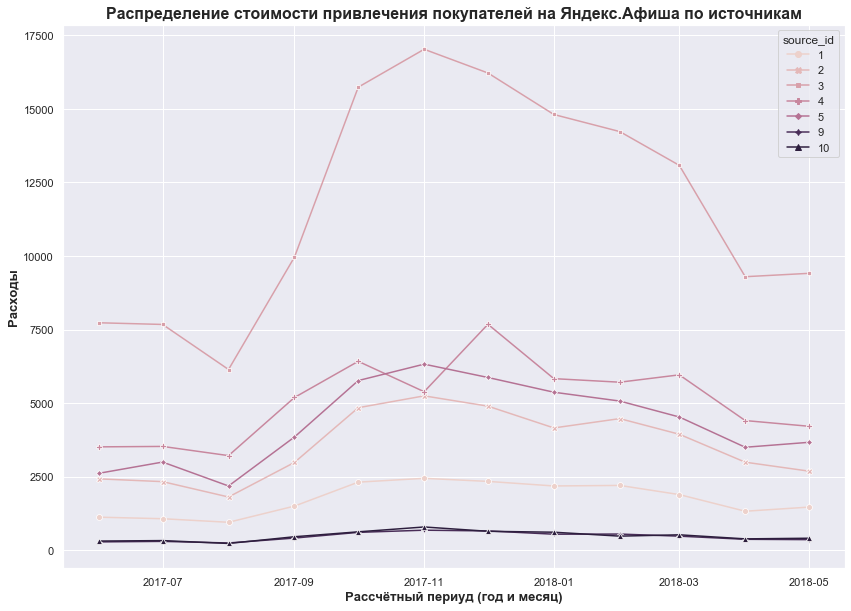

In [84]:
plt.figure(figsize = (14, 10))
sns.lineplot(
    x="date_month",
    y="costs",
    hue="source_id",
    style="source_id",
    legend='full',
    markers=True,
    dashes=False,
    data=costs_gr)
captions_to_graphics(
    'Распределение стоимости привлечения покупателей на Яндекс.Афиша по источникам',
    'Рассчётный периуд (год и месяц)',
    'Расходы')
plt.show()

**Самые высокие расходы на третий источник. На источники под номерами 9 и 10 потратили меньше всего денег.**

<a id=2_3_2></a>
### 2.3.2. Сколько стоило привлечение одного покупателя из каждого источника?
[Содержание](#content)

Воспользуемся очищенной таблицой покупок:

In [85]:
cohort_orders_clean.head(3)

,revenue,uid,cohort_lifetime,cohort_month,date
0,17.00,10329302124590727494,0,2017-06,2017-06-01
1,0.55,11627257723692907447,0,2017-06,2017-06-01
2,0.37,17903680561304213844,0,2017-06,2017-06-01


Создадим таблицу пользователей с привязкой к источнику и устройству:

In [86]:
users = visits\
    .sort_values(by=['uid', 'start_ts'])\
    .groupby('uid', as_index=False)\
    .agg({'device': 'first', 'source_id': 'first'})
users.head(3)

,uid,device,source_id
0,11863502262781,touch,3
1,49537067089222,touch,2
2,297729379853735,desktop,3


Объединим таблицы:

In [87]:
users_buyers = cohort_orders_clean.merge(users, how='left', on='uid')
users_buyers.head(3)

,revenue,uid,cohort_lifetime,cohort_month,date,device,source_id
0,17.00,10329302124590727494,0,2017-06,2017-06-01,desktop,1
1,0.55,11627257723692907447,0,2017-06,2017-06-01,desktop,2
2,0.37,17903680561304213844,0,2017-06,2017-06-01,desktop,2


Используем таблицу с расходами. Переименуем столбец с датой

In [88]:
costs.head(3)

,source_id,date,costs,date_month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01


Присоединим к таблице с покупателями:

In [89]:
users_buyers = users_buyers.merge(costs.drop('date_month', axis=1), how='left', on=('source_id', 'date'))
users_buyers.head()

,revenue,uid,cohort_lifetime,cohort_month,date,device,source_id,costs
0,17.00,10329302124590727494,0,2017-06,2017-06-01,desktop,1,75.20
1,0.55,11627257723692907447,0,2017-06,2017-06-01,desktop,2,132.56
2,0.37,17903680561304213844,0,2017-06,2017-06-01,desktop,2,132.56
3,0.55,16109239769442553005,0,2017-06,2017-06-01,desktop,2,132.56
4,0.37,14200605875248379450,0,2017-06,2017-06-01,desktop,3,349.38


Сгруппируем полученную таблицу по дате и источнику, посчитаем количество платящих пользователей, и стоимость привлечения в эту дату.
Поделим стоимость на количество покупателей.

In [90]:
users_costs = users_buyers.groupby(['date','source_id']).agg({'uid': 'count', 'costs': 'max'}).reset_index()
users_costs['cost_per_user'] = users_costs['costs'] / users_costs['uid']

users_costs.head(3)

,date,source_id,uid,costs,cost_per_user
0,2017-06-01,1,17,75.20,4.423529
1,2017-06-01,2,13,132.56,10.196923
2,2017-06-01,3,33,349.38,10.587273


Добавим к таблице пользователей, таблицу стоимости привлечения. Объединять будем по дате и источнику.

In [91]:
users_buyers = users_buyers.merge(users_costs[['date','source_id','cost_per_user']],
                                  how = 'left', on = ('date','source_id'))
users_buyers.head(3)

,revenue,uid,cohort_lifetime,cohort_month,date,device,source_id,costs,cost_per_user
0,17.00,10329302124590727494,0,2017-06,2017-06-01,desktop,1,75.20,4.423529
1,0.55,11627257723692907447,0,2017-06,2017-06-01,desktop,2,132.56,10.196923
2,0.37,17903680561304213844,0,2017-06,2017-06-01,desktop,2,132.56,10.196923


В таблице выше, мы рассчитали стоимость привлечения одного клиента. Осталось разбить их по источникам и устройствам.

In [92]:
cost_by_source = users_buyers.groupby(['source_id', 'device']).agg({'cost_per_user': 'mean'}).reset_index()
cost_by_source

,source_id,device,cost_per_user
0,1,desktop,4.003318
1,1,touch,3.940627
2,2,desktop,6.695976
3,2,touch,6.775162
4,3,desktop,10.659068
5,3,touch,10.551133
6,4,desktop,4.718882
7,4,touch,4.797133
8,5,desktop,5.525538
9,5,touch,5.456555


Всплыл источник под №7. Проверим, много ли клиентов он привлёк.

In [93]:
users_buyers['source_id'].value_counts()

3     13281
4     12890
5      9386
2      6379
1      5218
9      1647
10     1562
7         1
Name: source_id, dtype: int64

Всего один человек. Исключим из рассчёта. Построим график распределения стоимости привлечения по источникам и устройствам.

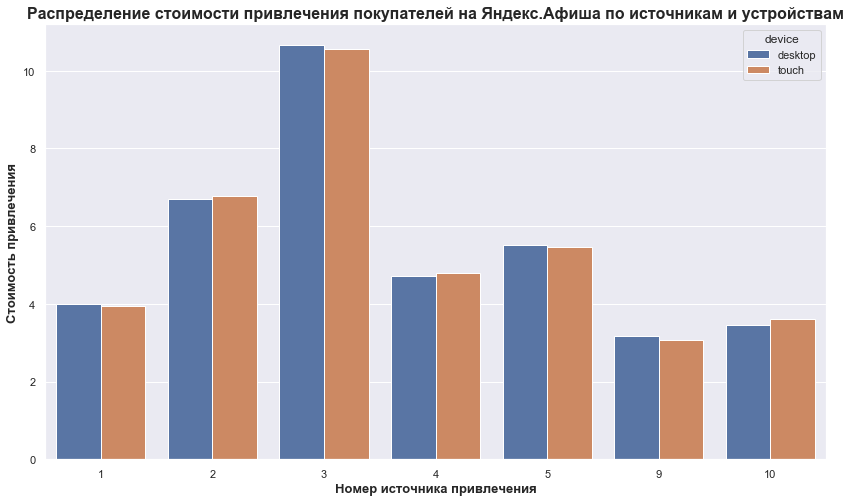

In [94]:
users_buyers = users_buyers[users_buyers['source_id'] != 7]

plt.figure(figsize=(14, 8))
sns.barplot(x='source_id',
            y='cost_per_user',
            hue='device',
            data=cost_by_source[cost_by_source['source_id'] != 7])
captions_to_graphics(
    'Распределение стоимости привлечения покупателей на Яндекс.Афиша по источникам и устройствам',
    'Номер источника привлечения',
    'Стоимость привлечения')
plt.show()

**Стоимость привлечения покупателей из источника №3 сильно выбивается. По устройствам разница не существенная. Источник 7 привлёк только одного(!) покупателя.**

<a id=2_3_3></a>
### 2.3.3. На сколько окупились расходы? (ROI)
[Содержание](#content)

Воспользуемся таблицей с данными LTV, и таблицей покупателей.

In [95]:
cohort_orders_ltv.head(3)

,cohort_month,cohort_lifetime,revenue,cohort_buyer,revenue_per_user,ltv
0,2017-06,0,8968.06,2032,4.413415,4.413415
1,2017-06,1,2361.64,2032,1.162224,1.162224
2,2017-06,2,1445.11,2032,0.711176,0.711176


In [96]:
users_buyers.head(3)

,revenue,uid,cohort_lifetime,cohort_month,date,device,source_id,costs,cost_per_user
0,17.00,10329302124590727494,0,2017-06,2017-06-01,desktop,1,75.20,4.423529
1,0.55,11627257723692907447,0,2017-06,2017-06-01,desktop,2,132.56,10.196923
2,0.37,17903680561304213844,0,2017-06,2017-06-01,desktop,2,132.56,10.196923


Сгруппируем по когортам, и рассчитаем среднюю стоимость привлечения пользователя.

In [97]:
cohort_cac = users_buyers[users_buyers['cohort_lifetime'] == 0]
cohort_cac = cohort_cac.groupby('cohort_month').\
    agg({'cost_per_user': 'mean'}).reset_index()

cohort_cac.head(3)

,cohort_month,cost_per_user
0,2017-06,7.653923
1,2017-07,7.748924
2,2017-08,8.476554


Добавим столбец со средней стоимостью привлечения клиента к таблице, с данными по LTV.

In [98]:
cohort_roi = cohort_orders_ltv[['cohort_month', 'cohort_lifetime', 'ltv']].merge(
    cohort_cac, how='left', on='cohort_month')
cohort_roi.head(3)

,cohort_month,cohort_lifetime,ltv,cost_per_user
0,2017-06,0,4.413415,7.653923
1,2017-06,1,1.162224,7.653923
2,2017-06,2,0.711176,7.653923


Рассчитаем ROI:

In [99]:
cohort_roi['roi'] = cohort_roi['ltv'] / cohort_roi['cost_per_user']
cohort_roi.head(3)

,cohort_month,cohort_lifetime,ltv,cost_per_user,roi
0,2017-06,0,4.413415,7.653923,0.576621
1,2017-06,1,1.162224,7.653923,0.151847
2,2017-06,2,0.711176,7.653923,0.092917


Создадим сводную таблицу по когортам и времени жизни и произведём накопительное суммирование:

In [100]:
cohort_roi_pivot = cohort_roi.pivot_table(
    index='cohort_month',
    columns='cohort_lifetime',
    values='roi',
    aggfunc='mean')

cohort_roi_pivot = cohort_roi_pivot.cumsum(axis=1).round(2)
cohort_roi_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,,
2017-06,0.58,0.73,0.82,1.00,1.27,1.41,1.63,1.76,1.93,2.12,2.26,2.36,2.39
2017-07,0.73,0.80,0.89,0.95,1.02,1.07,1.12,1.18,1.23,1.27,1.30,1.31,NaN
2017-08,0.61,0.71,0.80,0.90,0.96,1.01,1.07,1.16,1.24,1.27,1.27,NaN,NaN
2017-09,0.71,0.89,1.01,1.16,1.25,1.34,1.39,1.42,1.44,1.45,NaN,NaN,NaN
2017-10,0.75,0.88,0.95,0.99,1.04,1.08,1.10,1.12,1.13,NaN,NaN,NaN,NaN
2017-11,0.73,0.82,0.89,0.94,0.99,1.02,1.04,1.05,NaN,NaN,NaN,NaN,NaN
2017-12,0.72,0.81,0.86,0.91,0.94,0.97,0.97,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,0.57,0.66,0.72,0.73,0.76,0.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,0.65,0.74,0.78,0.81,0.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Построим тепловую карту.

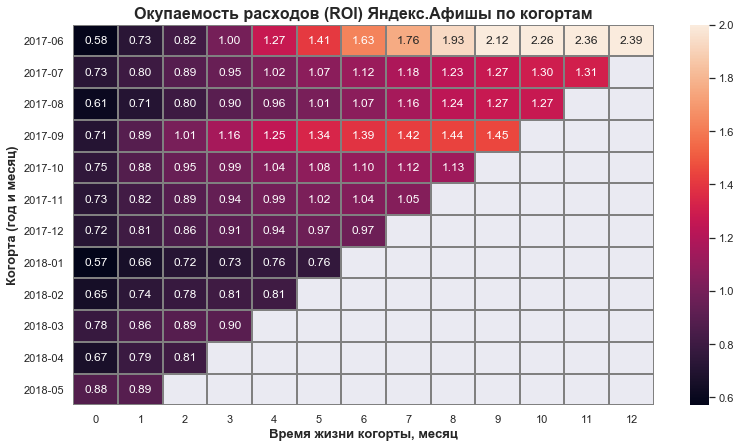

In [101]:
plt.figure(figsize = (13, 7))
sns.heatmap(
    cohort_roi_pivot,
    annot = True,
    fmt = '.2f',
    linewidths = 1,
    linecolor = 'grey',
    vmax = 2)
captions_to_graphics(
    'Окупаемость расходов (ROI) Яндекс.Афишы по когортам',
    'Время жизни когорты, месяц',
    'Когорта (год и месяц)')
plt.show()

Выделим данные по тем когортам, о которых есть данные за пол года:

In [102]:
cohort_roi_pivot_half_year = cohort_roi_pivot.loc['2017-06': '2018-01', '0': '5']
cohort_roi_pivot_half_year

cohort_lifetime,0,1,2,3,4,5
cohort_month,,,,,,
2017-06,0.58,0.73,0.82,1.00,1.27,1.41
2017-07,0.73,0.80,0.89,0.95,1.02,1.07
2017-08,0.61,0.71,0.80,0.90,0.96,1.01
2017-09,0.71,0.89,1.01,1.16,1.25,1.34
2017-10,0.75,0.88,0.95,0.99,1.04,1.08
2017-11,0.73,0.82,0.89,0.94,0.99,1.02
2017-12,0.72,0.81,0.86,0.91,0.94,0.97
2018-01,0.57,0.66,0.72,0.73,0.76,0.76


Рассчитаем средний ROI по когортам:

In [103]:
cohort_roi_pivot_half_year.mean(axis=0).round(2)

cohort_lifetime
0    0.68
1    0.79
2    0.87
3    0.95
4    1.03
5    1.08
dtype: float64

**В среднем, когорты окупаются к концу 5 месяца. При этом, ROI неуклонно падает от когорты к когорте. Исключение - сентябрьская когорта.**

Рассчитаем ROI для каждого источника. Воспользуемся таблицей покупателей:

In [104]:
users_buyers.head(3)

,revenue,uid,cohort_lifetime,cohort_month,date,device,source_id,costs,cost_per_user
0,17.00,10329302124590727494,0,2017-06,2017-06-01,desktop,1,75.20,4.423529
1,0.55,11627257723692907447,0,2017-06,2017-06-01,desktop,2,132.56,10.196923
2,0.37,17903680561304213844,0,2017-06,2017-06-01,desktop,2,132.56,10.196923


Сгруппируем данные о стоимости покупок по источнику, когорте, и времени жизни:

In [105]:
roi_source_id = users_buyers\
    .groupby(['source_id', 'cohort_month', 'cohort_lifetime'], as_index=False)\
    .agg({'revenue': 'sum'})
roi_source_id.head(3)

,source_id,cohort_month,cohort_lifetime,revenue
0,1,2017-06,0,1258.65
1,1,2017-06,1,491.80
2,1,2017-06,2,608.55


Создадим таблицу с количеством покупателей, и стоимостью превлечения. Данные группируем по источнику, когорте, и времени жизни:

In [106]:
source_id_uid_cost = users_buyers[users_buyers['cohort_lifetime'] == 0]\
    .groupby(['source_id', 'cohort_month'], as_index=False)\
    .agg({'uid': 'nunique', 'cost_per_user': 'mean'})
source_id_uid_cost.head(3)

,source_id,cohort_month,uid,cost_per_user
0,1,2017-06,190,4.013450
1,1,2017-07,148,4.040861
2,1,2017-08,102,3.940540


Объединяем таблицы:

In [107]:
roi_source_id = roi_source_id.merge(source_id_uid_cost, how='left', on=('source_id', 'cohort_month'))
roi_source_id.head(3)

,source_id,cohort_month,cohort_lifetime,revenue,uid,cost_per_user
0,1,2017-06,0,1258.65,190,4.01345
1,1,2017-06,1,491.80,190,4.01345
2,1,2017-06,2,608.55,190,4.01345


Рассчитаем ROI для каждой группы:

In [108]:
roi_source_id['revenue_per_user'] = roi_source_id['revenue'] / roi_source_id['uid']
roi_source_id['ltv'] = roi_source_id['revenue_per_user'] * margin_rate
roi_source_id['roi'] = roi_source_id['ltv'] / roi_source_id['cost_per_user']

roi_source_id.head(3)

,source_id,cohort_month,cohort_lifetime,revenue,uid,cost_per_user,revenue_per_user,ltv,roi
0,1,2017-06,0,1258.65,190,4.01345,6.624474,6.624474,1.650568
1,1,2017-06,1,491.80,190,4.01345,2.588421,2.588421,0.644937
2,1,2017-06,2,608.55,190,4.01345,3.202895,3.202895,0.798040


Построим тепловые карты по каждому источнику:

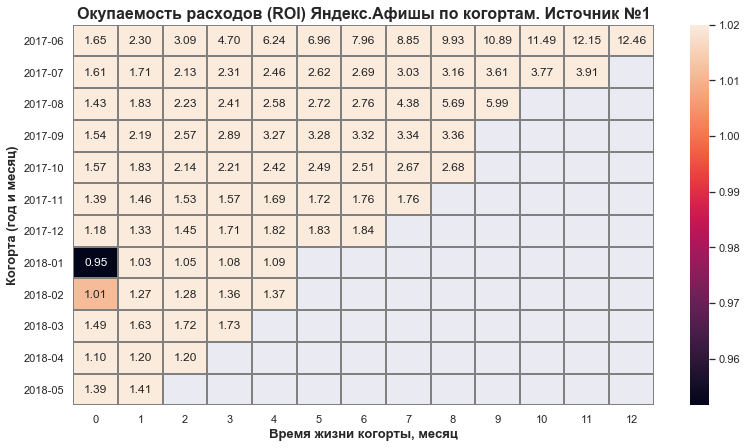

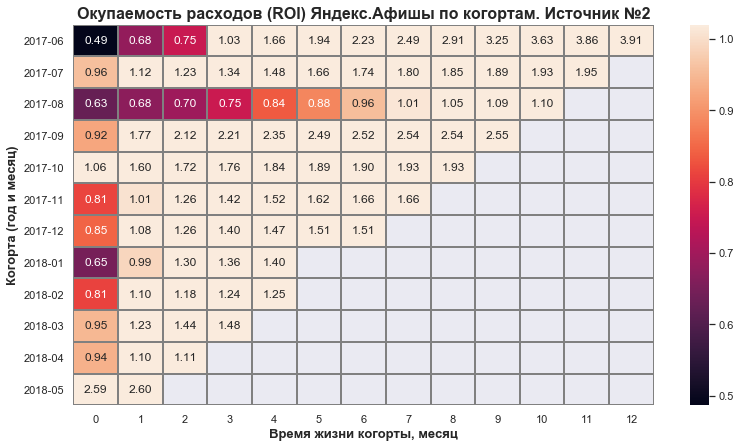

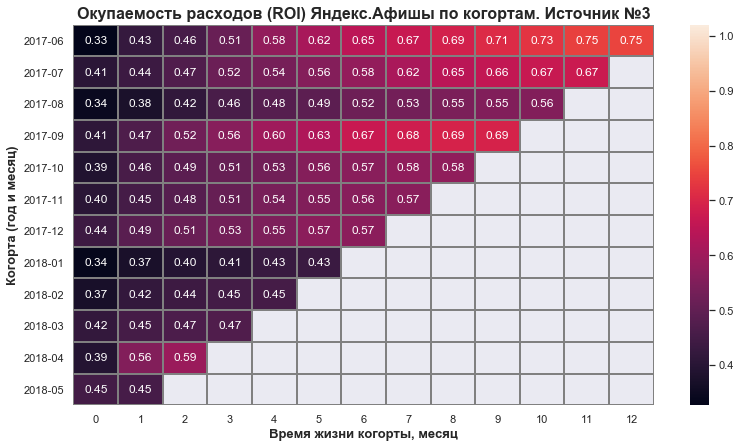

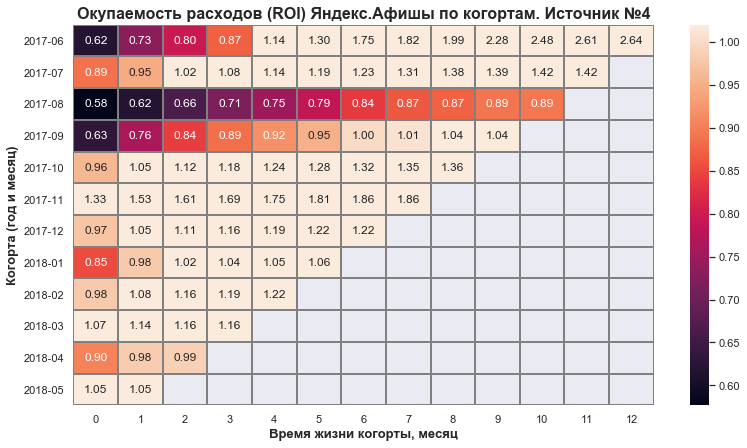

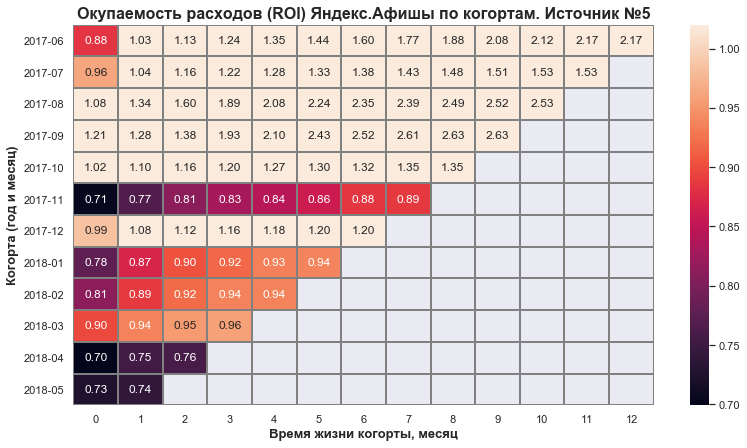

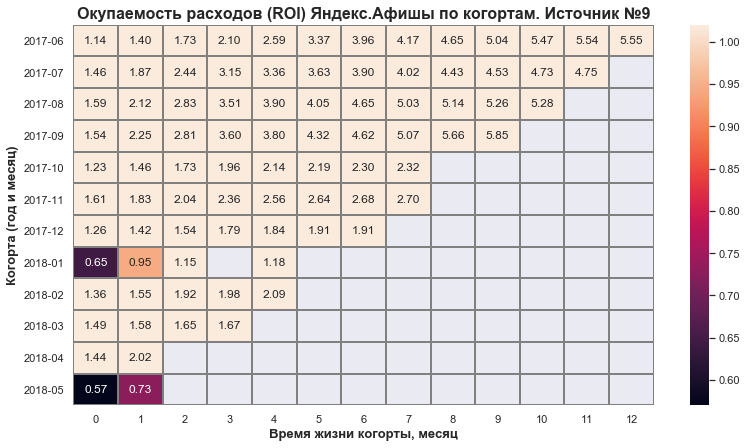

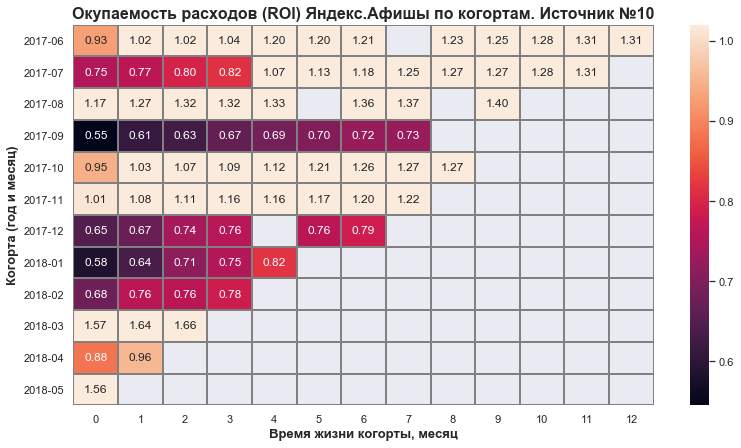

In [109]:
for source in roi_source_id['source_id'].unique():
    data_pivot = roi_source_id[roi_source_id['source_id'] == source]\
    .pivot_table(index='cohort_month',
                 columns='cohort_lifetime',
                 values='roi',
                 aggfunc='mean')

    data_pivot = data_pivot.cumsum(axis=1)

    plt.figure(figsize = (13, 7))
    sns.heatmap(data_pivot,
                annot = True,
                fmt = '.2f',
                linewidths = 1,
                linecolor = 'grey',
                vmax = 1.02)
    captions_to_graphics(
        'Окупаемость расходов (ROI) Яндекс.Афишы по когортам. Источник №' + str(source),
        'Время жизни когорты, месяц',
        'Когорта (год и месяц)')
    plt.show()

**В среднем, практически все источники показывают окупаемость в первый месяц жизни когорты. Источник №3 - исключение.**

Выберем данные за пол года жизни когорт:

In [110]:
roi_source_id_half_year = roi_source_id[
    (roi_source_id['cohort_month'] <= '2017-12') &
    (roi_source_id['cohort_lifetime'] <= 5)]
roi_source_id_half_year.head(7)

,source_id,cohort_month,cohort_lifetime,revenue,uid,cost_per_user,revenue_per_user,ltv,roi
0,1,2017-06,0,1258.65,190,4.013450,6.624474,6.624474,1.650568
1,1,2017-06,1,491.80,190,4.013450,2.588421,2.588421,0.644937
2,1,2017-06,2,608.55,190,4.013450,3.202895,3.202895,0.798040
3,1,2017-06,3,1224.56,190,4.013450,6.445053,6.445053,1.605863
4,1,2017-06,4,1177.93,190,4.013450,6.199632,6.199632,1.544714
5,1,2017-06,5,548.57,190,4.013450,2.887211,2.887211,0.719384
13,1,2017-07,0,964.78,148,4.040861,6.518784,6.518784,1.613216


Сгруппируем по источнику и времени жизни:

In [111]:
roi_source_id_lifetime = roi_source_id_half_year\
    .groupby(['source_id', 'cohort_lifetime'])\
    .agg({'roi': 'mean'})\
    .reset_index()
roi_source_id_lifetime.head()

,source_id,cohort_lifetime,roi
0,1,0,1.481595
1,1,1,0.323077
2,1,2,0.357717
3,1,3,0.380554
4,1,4,0.384623


Построим график окупаемости источников по времени жизни когорт:

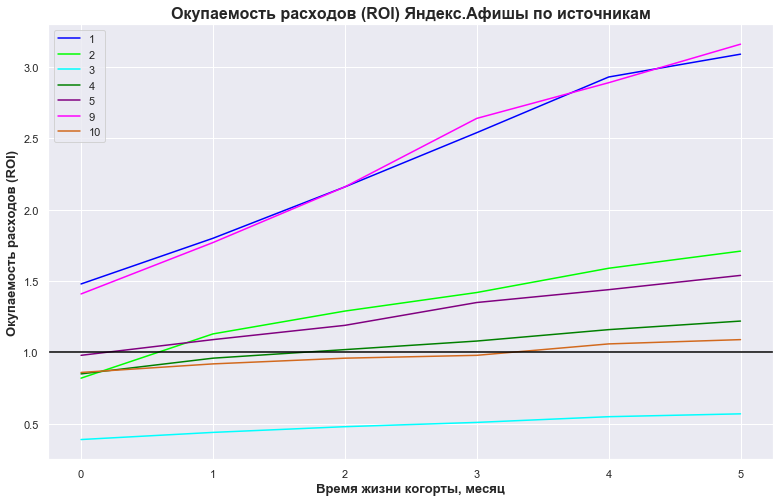

In [112]:
pal = {1:'#0000FF',
       2:'#00FF00',
       3:'#00FFFF',
       4:'#008000',
       5:'#800080',
       9:'#FF00FF',
       10:'#D2691E'
      }

plt.figure(figsize = (13, 8))

for source in roi_source_id_lifetime['source_id'].unique():
    data_roi = roi_source_id_lifetime[roi_source_id_lifetime['source_id'] == source].copy()
    data_roi['roi_cumsum'] = data_roi['roi'].cumsum(axis=0).round(2)
    
    sns.lineplot(
        x=data_roi['cohort_lifetime'],
        y=data_roi['roi_cumsum'],
        data=data_roi,
        color=pal[source],
        label=source)
    
captions_to_graphics(
    'Окупаемость расходов (ROI) Яндекс.Афишы по источникам',
    'Время жизни когорты, месяц',
    'Окупаемость расходов (ROI)')
plt.legend(loc='upper left')
plt.axhline(
    y=1,
    color='black',
    linestyle='-')

plt.show()

**Источник №3 не окупается даже за год. У источников №9 и №10 самые высокие показатели.**

<a id=conclusion></a>
## 3. Вывод.
[Содержание](#content)

- **Количество уникальных пользователей:**
    - **в день   (DAU) - 907**
    - **в неделю (WAU) - 4911**
    - **в месяц  (MAU) - 23228**


- **В среднем, пользователь делает одну сессию в день. На повторные посещения приходится 7.6% визитов.**


- **Cредняя продолжительность сессии (ASL) равна 1й минуте, и 50% сессий длятся не более 5 минут.Существует выброс в четверть процента с длительностью сессий в 19 секунд**


- **Retention Rate посетителей Яндекс.Афиша в первый месяц составляет менее 7 %, и начиная с сентября 2017 неуклонно падает. Лучший месяц - сентябрь 2017 года. Когорта этого месяца имеет самый высокий показатель Retention Rate первого месяца. Так же, в этот месяц наблюдается небольшое повышение Retention Rate для предыдущих когорт. Возможно, это связано с сезонностью.**


- **В течении 15 минут совершается почти половина покупок (49.2%).**


- **Самая стабильная когорта по количеству покупок - "2017-06". В остальных когортах количество покупок неуклонно падает. С октября по декабрь наблюдается пик продаж. В среднем, за пол года жизни, пользователь совершает 1.3 покупки.**


- **Средний чек за первые пол года жизни когорт - 5.9. Средний чек падает от когорты к когорте. Исключение - сентябрьская когорта. Самый высокий средний чек у покупателей июньской когорты (2017-06).**


- **Среднее LTV за пол года - 7.82. LTV по когортам упало за 7 месяцев почти вдвое.**


- **Стоимость привлечения покупателей из источника №3 сильно выбивается. По устройствам разница не существенная. Источник 7 привлёк только одного(!) покупателя.**


- **В среднем, когорты окупаются к концу 5 месяца. При этом, ROI неуклонно падает от когорты к когорте. Исключение - сентябрьская когорта. Источник №3 не окупается даже за год. У источников №9 и №10 самые высокие показатели окупаемости.**

<a id=recommendation></a>
## 4. Рекомендация маркетологам.

### Рекомендую полностью отказаться от затрат на источник №3, в пользу источников №1 и №9.